In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Epoch 1/10, Loss: 168.4900
Epoch 2/10, Loss: 126.3388
Epoch 3/10, Loss: 117.0091
Epoch 4/10, Loss: 112.9391
Epoch 5/10, Loss: 110.5175
Epoch 6/10, Loss: 109.0384
Epoch 7/10, Loss: 107.9909
Epoch 8/10, Loss: 107.2302
Epoch 9/10, Loss: 106.6545
Epoch 10/10, Loss: 106.1219


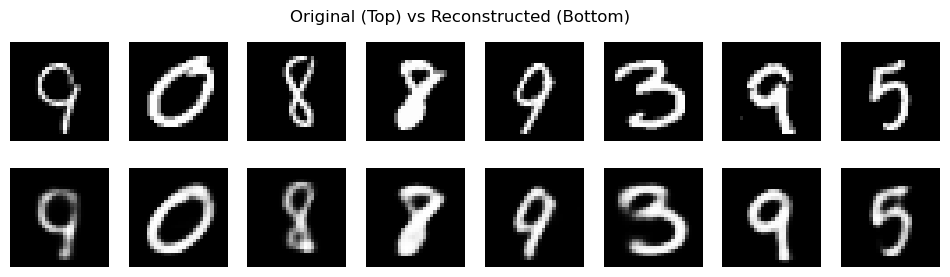

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=50):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

# Visualize original and reconstructed images
model.eval()
with torch.no_grad():
    sample = next(iter(train_loader))[0][:8].view(-1, 784).to(device)
    recon, _, _ = model(sample)

    sample = sample.view(-1, 1, 28, 28).cpu()
    recon = recon.view(-1, 1, 28, 28).cpu()

    plt.figure(figsize=(12, 3))
    for i in range(8):
        # Original
        plt.subplot(2, 8, i + 1)
        plt.imshow(sample[i][0], cmap='gray')
        plt.axis('off')
        # Reconstructed
        plt.subplot(2, 8, i + 9)
        plt.imshow(recon[i][0], cmap='gray')
        plt.axis('off')
    plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
    plt.show()

In [ ]:
# Classifier+VAE


# === IMPORTS ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === VAE WITH CLASSIFIER ===
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=50, num_classes=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits

# === LOSS FUNCTION ===
def loss_function(recon_x, x, mu, logvar, logits, labels, alpha=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    CE = F.cross_entropy(logits, labels, reduction='sum')
    return BCE + KLD + alpha * CE

# === LOAD MNIST ===
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='/kaggle/working', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/kaggle/working', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# === INIT MODEL ===
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRAINING LOOP ===
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, logits = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, logits, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

# === TEST CLASSIFICATION ACCURACY ===
model.eval()
correct = 0
total = 0
all_preds, all_labels = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        _, _, _, logits = model(data)
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

print(f"\n🎯 Test Accuracy: {100 * correct / total:.2f}%")

# === VISUALIZE ORIGINAL, RECONSTRUCTED, PREDICTED ===
with torch.no_grad():
    images, labels = next(iter(test_loader))
    data = images[:8].view(-1, 784).to(device)
    recon, _, _, logits = model(data)
    preds = logits.argmax(dim=1).cpu().numpy()
    images = images[:8].view(-1, 1, 28, 28).cpu()
    recon = recon.view(-1, 1, 28, 28).cpu()

    plt.figure(figsize=(12, 4))
    for i in range(8):
        # Original
        plt.subplot(3, 8, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"T:{labels[i].item()}")
        plt.axis('off')
        # Reconstructed
        plt.subplot(3, 8, i + 9)
        plt.imshow(recon[i][0], cmap='gray')
        plt.title(f"P:{preds[i]}")
        plt.axis('off')
    plt.suptitle("Original (Top), Reconstructed (Middle), Predicted Label (Bottom)")
    plt.tight_layout()
    plt.show()

# === CONFUSION MATRIX ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# === t-SNE VISUALIZATION OF LATENT SPACE ===
zs = []
ys = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        zs.append(z.cpu())
        ys.append(target)

zs = torch.cat(zs).numpy()
ys = torch.cat(ys).numpy()

tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(zs)

df = pd.DataFrame({
    'tsne-1': z_tsne[:, 0],
    'tsne-2': z_tsne[:, 1],
    'label': ys
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='tsne-1', y='tsne-2', hue='label', palette='tab10', s=30)
plt.title("t-SNE of Latent Space (colored by digit)")
plt.legend()
plt.show()

In [ ]:
# === IMPORTS ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === VAE WITH CLASSIFIER ===
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=50, num_classes=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits

# === LOSS FUNCTION ===
def loss_function(recon_x, x, mu, logvar, logits, labels, alpha=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    CE = F.cross_entropy(logits, labels, reduction='sum')
    return BCE + KLD + alpha * CE

# === LOAD MNIST ===
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='/kaggle/working', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/kaggle/working', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# === INIT MODEL ===
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRAINING & EVALUATION LOOP ===
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, logits = model(data)
        loss = loss_function(recon, data, mu, logvar, logits, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100. * correct / total)

    # Evaluate on test
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, mu, logvar, logits = model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%")

# === PLOT LOSSES AND ACCURACIES ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(test_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.plot(test_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.legend()
plt.tight_layout()
plt.show()

# === RECONSTRUCTIONS & PREDICTIONS ===
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    data = images[:8].view(-1, 784).to(device)
    recon, _, _, logits = model(data)
    preds = logits.argmax(dim=1).cpu().numpy()
    images = images[:8].cpu()
    recon = recon.view(-1, 1, 28, 28).cpu()

    plt.figure(figsize=(12, 4))
    for i in range(8):
        plt.subplot(3, 8, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"T:{labels[i].item()}")
        plt.axis('off')
        plt.subplot(3, 8, i + 9)
        plt.imshow(recon[i][0], cmap='gray')
        plt.title(f"P:{preds[i]}")
        plt.axis('off')
    plt.suptitle("Original (Top), Reconstructed (Middle), Predicted (Bottom)")
    plt.tight_layout()
    plt.show()

# === CONFUSION MATRIX ===
all_preds, all_labels = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        logits = model(data)[-1]
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(target.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# === t-SNE OF LATENT SPACE ===
zs, ys = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        zs.append(z.cpu())
        ys.append(target)

zs = torch.cat(zs).numpy()
ys = torch.cat(ys).numpy()
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(zs)

df = pd.DataFrame({
    'tsne-1': z_2d[:, 0],
    'tsne-2': z_2d[:, 1],
    'label': ys
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='tsne-1', y='tsne-2', hue='label', palette='tab10', s=40)
plt.title("t-SNE of Latent Space")
plt.show()



Using device: cpu


100%|██████████| 9.91M/9.91M [00:01<00:00, 8.20MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.97MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.58MB/s]


Epoch 1/10, Train Loss: 170.6955, Test Loss: 135.1822, Train Acc: 56.25%, Test Acc: 76.70%
Epoch 2/10, Train Loss: 127.6860, Test Loss: 120.4549, Train Acc: 78.66%, Test Acc: 81.04%
Epoch 3/10, Train Loss: 117.9796, Test Loss: 114.4174, Train Acc: 81.92%, Test Acc: 83.70%
Epoch 4/10, Train Loss: 113.6319, Test Loss: 111.1097, Train Acc: 83.94%, Test Acc: 85.56%
Epoch 5/10, Train Loss: 111.2121, Test Loss: 109.6895, Train Acc: 85.21%, Test Acc: 86.57%
Epoch 6/10, Train Loss: 109.7150, Test Loss: 108.4141, Train Acc: 85.76%, Test Acc: 86.45%
Epoch 7/10, Train Loss: 108.6405, Test Loss: 107.6448, Train Acc: 86.17%, Test Acc: 86.96%
Epoch 8/10, Train Loss: 107.8726, Test Loss: 106.9185, Train Acc: 86.61%, Test Acc: 87.53%
Epoch 9/10, Train Loss: 107.3118, Test Loss: 106.4857, Train Acc: 86.70%, Test Acc: 88.06%
Epoch 10/10, Train Loss: 106.8258, Test Loss: 105.9447, Train Acc: 87.05%, Test Acc: 88.29%


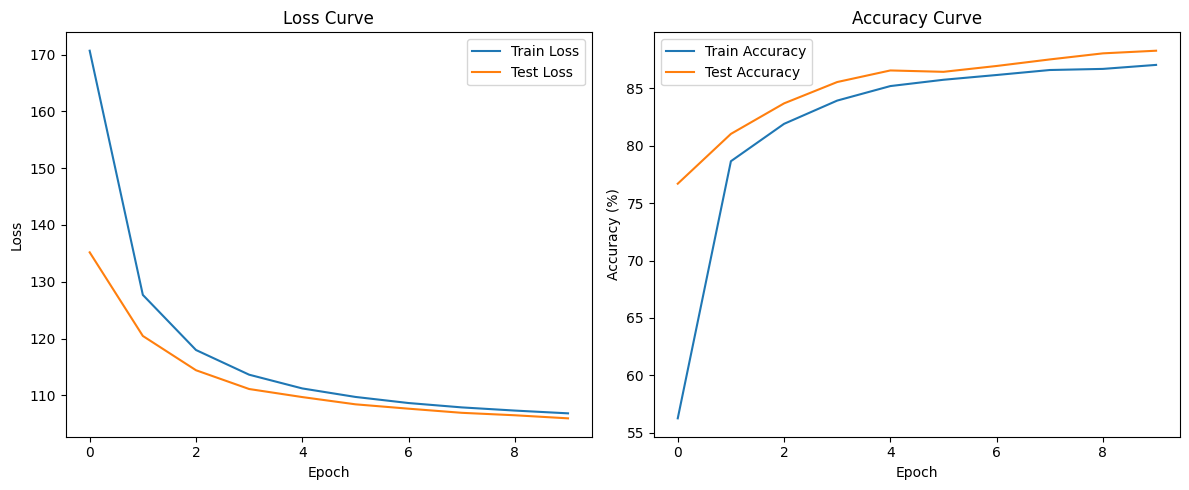

ReconClassifier Epoch 1, Loss: 161.37, Train Acc: 90.56%
ReconClassifier Epoch 2, Loss: 58.14, Train Acc: 96.32%
ReconClassifier Epoch 3, Loss: 39.45, Train Acc: 97.42%
ReconClassifier Epoch 4, Loss: 29.30, Train Acc: 98.06%
ReconClassifier Epoch 5, Loss: 21.42, Train Acc: 98.58%
Accuracy on Reconstructed Images: 95.51%


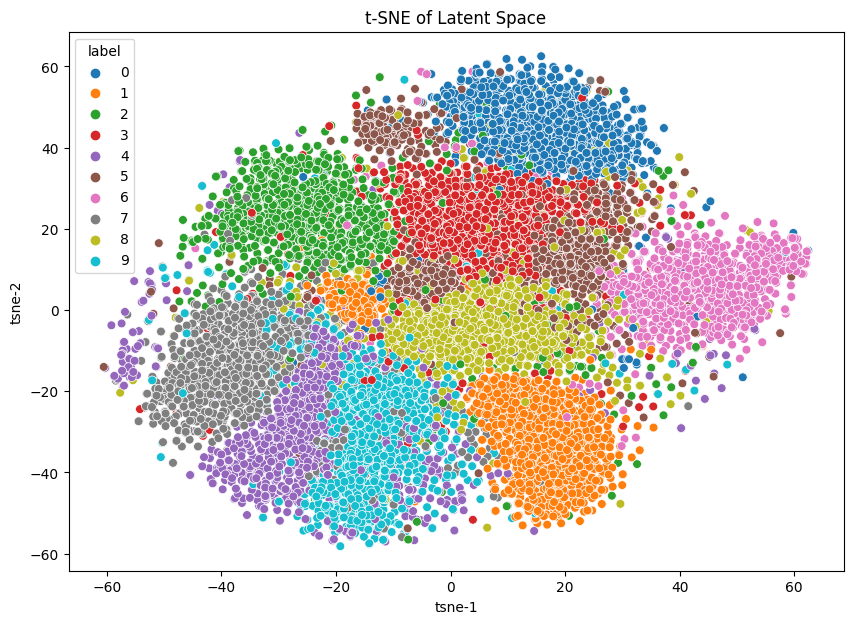

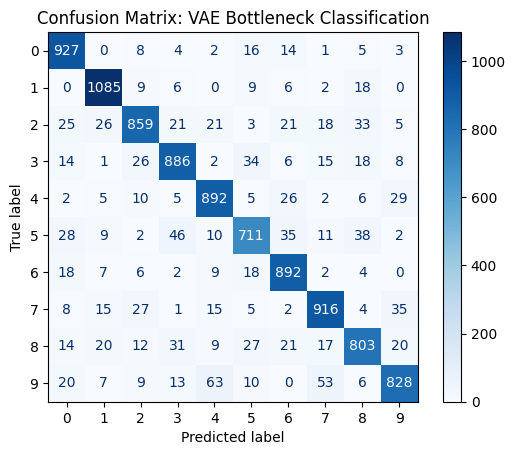

In [ ]:
# === IMPORTS ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === VAE WITH CLASSIFIER ===
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=50, num_classes=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits

# === RECONSTRUCTION CLASSIFIER ===
class ReconClassifier(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(ReconClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# === LOSS FUNCTION ===
def loss_function(recon_x, x, mu, logvar, logits, labels, alpha=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    CE = F.cross_entropy(logits, labels, reduction='sum')
    return BCE + KLD + alpha * CE

# === LOAD MNIST ===
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='/kaggle/working', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/kaggle/working', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# === INIT MODEL ===
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRAIN VAE ===
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, logits = model(data)
        loss = loss_function(recon, data, mu, logvar, logits, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100. * correct / total)

    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, mu, logvar, logits = model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%")

# === PLOT LOSS AND ACCURACY ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()

# === TRAIN SEPARATE CLASSIFIER ON ORIGINAL IMAGES ===
recon_clf = ReconClassifier().to(device)
clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)
clf_epochs = 5

for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        clf_optimizer.zero_grad()
        logits = recon_clf(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()
        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {100.*correct/total:.2f}%")

# === ACCURACY ON RECONSTRUCTED IMAGES ===
recon_clf.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        recon, _, _, _ = model(data)
        logits = recon_clf(recon)
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
print(f"Accuracy on Reconstructed Images: {100. * correct / total:.2f}%")

# === t-SNE OF LATENT SPACE ===
zs, ys = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        zs.append(z.cpu())
        ys.append(target)

zs = torch.cat(zs).numpy()
ys = torch.cat(ys).numpy()
tsne = TSNE(n_components=2, random_state=42)
z_2d = tsne.fit_transform(zs)

df = pd.DataFrame({
    'tsne-1': z_2d[:, 0],
    'tsne-2': z_2d[:, 1],
    'label': ys
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='tsne-1', y='tsne-2', hue='label', palette='tab10', s=40)
plt.title("t-SNE of Latent Space")
plt.show()

# === CONFUSION MATRIX FROM BOTTLENECK CLASSIFICATION ===
all_preds, all_labels = [], []
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        logits = model(data)[-1]
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(target.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: VAE Bottleneck Classification")
plt.show()

In [ ]:
# Define latent dimensions
latent_dims = [3, 10, 25, 100, 300]

# Initialize results storage
results = {
    'latent_dim': [],
    'train_acc': [],
    'test_acc': [],
    'recon_acc': [],
    'train_loss': [],
    'test_loss': [],
    'recon_error': []  # <--- Added RMSE
}

# Loop over different latent dimensions
for latent_dim in latent_dims:
    print(f"\n=== Training VAE with latent dim = {latent_dim} ===")
    model = VAE(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(5):  # quick training
        model.train()
        for data, target in train_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, logits = model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target)
            loss.backward()
            optimizer.step()

    # === Evaluate classification from latent representation ===
    def evaluate(loader):
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for data, target in loader:
                data = data.view(-1, 784).to(device)
                target = target.to(device)
                recon, mu, logvar, logits = model(data)
                loss = loss_function(recon, data, mu, logvar, logits, target)
                total_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)
        return total_loss / len(loader.dataset), 100. * correct / total

    train_loss, train_acc = evaluate(train_loader)
    test_loss, test_acc = evaluate(test_loader)

    # === Train classifier on reconstructed images ===
    recon_clf = ReconClassifier().to(device)
    clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)
    for epoch in range(2):
        recon_clf.train()
        for data, target in train_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, _, _, _ = model(data)
            clf_optimizer.zero_grad()
            logits = recon_clf(recon)
            loss = F.cross_entropy(logits, target)
            loss.backward()
            clf_optimizer.step()

    # === Evaluate classifier on reconstructed test images ===
    recon_clf.eval()
    recon_correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, _, _, _ = model(data)
            logits = recon_clf(recon)
            preds = logits.argmax(dim=1)
            recon_correct += (preds == target).sum().item()
            total += target.size(0)
    recon_acc = 100. * recon_correct / total

    # === Compute RMSE Reconstruction Error ===
    total_squared_error = 0.0
    total_pixels = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784).to(device)
            recon, _, _, _ = model(data)
            squared_error = (recon - data) ** 2
            total_squared_error += squared_error.sum().item()
            total_pixels += data.numel()
    rmse = (total_squared_error / total_pixels) ** 0.5

    # === Store results ===
    results['latent_dim'].append(latent_dim)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
    results['recon_acc'].append(recon_acc)
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['recon_error'].append(rmse)

# === PLOT COMPARISONS ===
plt.figure(figsize=(15, 5))

# 1. Classification Accuracy
plt.subplot(1, 3, 1)
plt.plot(results['latent_dim'], results['train_acc'], label='Train Acc', marker='o')
plt.plot(results['latent_dim'], results['test_acc'], label='Test Acc', marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("Accuracy (%)")
plt.title("VAE Classification Accuracy")
plt.legend()

# 2. VAE Loss
plt.subplot(1, 3, 2)
plt.plot(results['latent_dim'], results['train_loss'], label='Train Loss', marker='o')
plt.plot(results['latent_dim'], results['test_loss'], label='Test Loss', marker='o')
plt.xlabel("Latent Dimension")
plt.ylabel("Loss")
plt.title("VAE Loss")
plt.legend()

# 3. Reconstructed Image Classification Accuracy
plt.subplot(1, 3, 3)
plt.plot(results['latent_dim'], results['recon_acc'], label='Recon Image Acc', marker='o', color='purple')
plt.xlabel("Latent Dimension")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy on Reconstructed Images")
plt.legend()

plt.tight_layout()
plt.show()

# === Plot RMSE Reconstruction Error ===
plt.figure(figsize=(6, 4))
plt.plot(results['latent_dim'], results['recon_error'], marker='o', color='darkred')
plt.xlabel("Latent Dimension")
plt.ylabel("Reconstruction Error (RMSE)")
plt.title("Reconstruction Error vs Latent Dimension")
plt.grid(True)
plt.tight_layout()
plt.show()


=== Training VAE with latent dim = 3 ===


NameError: name 'VAE' is not defined

In [ ]:
print(results['recon_error'])

[0.1993900203653846, 0.14173397012263672, 0.12030437334662522, 0.12178735513784332, 0.1301166649686986]



=== Training VAE with alpha = 0 ===

=== Training VAE with alpha = 0.1 ===

=== Training VAE with alpha = 0.5 ===

=== Training VAE with alpha = 1 ===

=== Training VAE with alpha = 5 ===

=== Training VAE with alpha = 10 ===


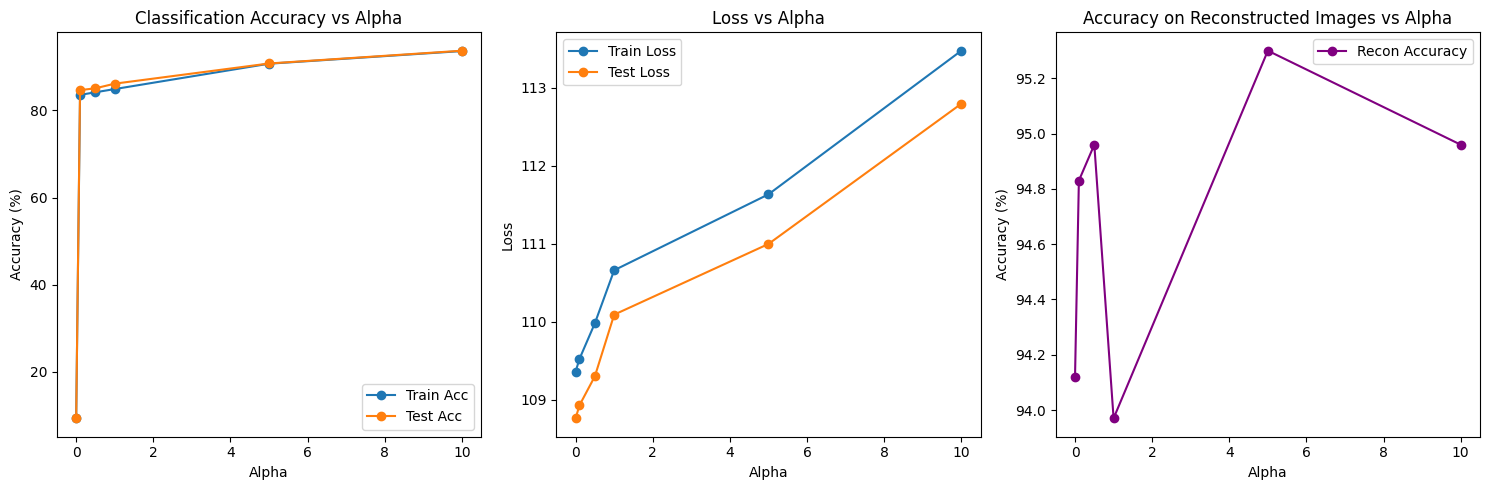

In [ ]:
# === ALPHA COMPARISON ===
alpha_values = [0, 0.1, 0.5, 1, 5, 10]
latent_dim = 50  # fixed latent dimension

alpha_results = {
    'alpha': [],
    'train_acc': [],
    'test_acc': [],
    'recon_acc': [],
    'train_loss': [],
    'test_loss': []
}

for alpha in alpha_values:
    print(f"\n=== Training VAE with alpha = {alpha} ===")
    model = VAE(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(5):  # fewer epochs for speed
        model.train()
        for data, target in train_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            optimizer.zero_grad()
            recon, mu, logvar, logits = model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target, alpha=alpha)
            loss.backward()
            optimizer.step()

    # Evaluate classification from bottleneck
    def evaluate(loader):
        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for data, target in loader:
                data = data.view(-1, 784).to(device)
                target = target.to(device)
                recon, mu, logvar, logits = model(data)
                loss = loss_function(recon, data, mu, logvar, logits, target, alpha=alpha)
                total_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)
        return total_loss / len(loader.dataset), 100. * correct / total

    train_loss, train_acc = evaluate(train_loader)
    test_loss, test_acc = evaluate(test_loader)

    # Recon classifier
    recon_clf = ReconClassifier().to(device)
    clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)
    for epoch in range(2):
        recon_clf.train()
        for data, target in train_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, _, _, _ = model(data)
            clf_optimizer.zero_grad()
            logits = recon_clf(recon)
            loss = F.cross_entropy(logits, target)
            loss.backward()
            clf_optimizer.step()

    recon_clf.eval()
    recon_correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, _, _, _ = model(data)
            logits = recon_clf(recon)
            preds = logits.argmax(dim=1)
            recon_correct += (preds == target).sum().item()
            total += target.size(0)
    recon_acc = 100. * recon_correct / total

    alpha_results['alpha'].append(alpha)
    alpha_results['train_acc'].append(train_acc)
    alpha_results['test_acc'].append(test_acc)
    alpha_results['recon_acc'].append(recon_acc)
    alpha_results['train_loss'].append(train_loss)
    alpha_results['test_loss'].append(test_loss)

# === PLOT ALPHA COMPARISON ===
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(alpha_results['alpha'], alpha_results['train_acc'], label='Train Acc', marker='o')
plt.plot(alpha_results['alpha'], alpha_results['test_acc'], label='Test Acc', marker='o')
plt.xlabel("Alpha")
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy vs Alpha")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(alpha_results['alpha'], alpha_results['train_loss'], label='Train Loss', marker='o')
plt.plot(alpha_results['alpha'], alpha_results['test_loss'], label='Test Loss', marker='o')
plt.xlabel("Alpha")
plt.ylabel("Loss")
plt.title("Loss vs Alpha")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(alpha_results['alpha'], alpha_results['recon_acc'], label='Recon Accuracy', marker='o', color='purple')
plt.xlabel("Alpha")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy on Reconstructed Images vs Alpha")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# === IMPORTS ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np

# === DEVICE ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === VAE WITH CLASSIFIER ===
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=50, num_classes=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        logits = self.classifier(z)
        return recon, mu, logvar, logits

# === RECONSTRUCTION CLASSIFIER ===
class ReconClassifier(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(ReconClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# === LOSS FUNCTION ===
def loss_function(recon_x, x, mu, logvar, logits, labels, alpha=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    CE = F.cross_entropy(logits, labels, reduction='sum')
    return BCE + KLD + alpha * CE

# === LOAD MNIST ===
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='/kaggle/working', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/kaggle/working', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# === INIT MODELS ===
vae_model = VAE().to(device)
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
recon_clf = ReconClassifier().to(device)
clf_optimizer = torch.optim.Adam(recon_clf.parameters(), lr=1e-3)

# === TRAIN VAE ===
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
epochs = 10

for epoch in range(epochs):
    vae_model.train()
    train_loss = 0
    correct, total = 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar, logits = vae_model(data)
        loss = loss_function(recon, data, mu, logvar, logits, target)
        loss.backward()
        vae_optimizer.step()
        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100. * correct / total)

    vae_model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 784).to(device)
            target = target.to(device)
            recon, mu, logvar, logits = vae_model(data)
            loss = loss_function(recon, data, mu, logvar, logits, target)
            test_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100. * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Test Acc: {test_accuracies[-1]:.2f}%")

# === TRAIN RECONSTRUCTION CLASSIFIER ON ORIGINAL IMAGES ===
clf_epochs = 5
for epoch in range(clf_epochs):
    recon_clf.train()
    total, correct, clf_loss = 0, 0, 0
    for data, target in train_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        clf_optimizer.zero_grad()
        logits = recon_clf(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        clf_optimizer.step()
        clf_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
    print(f"ReconClassifier Epoch {epoch+1}, Loss: {clf_loss:.2f}, Train Acc: {100.*correct/total:.2f}%")

# === EVALUATE CLASSIFIER ON RECONSTRUCTED IMAGES ===
recon_clf.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.view(-1, 784).to(device)
        target = target.to(device)
        recon, _, _, _ = vae_model(data)
        logits = recon_clf(recon)
        preds = logits.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.size(0)
recon_acc = 100. * correct / total
print(f"Accuracy on Reconstructed Images (Separate Classifier): {recon_acc:.2f}%")

# === PLOT COMPARISON ===
plt.figure(figsize=(8, 5))
plt.bar(['Latent Classification', 'Reconstruction Classification'], [test_accuracies[-1], recon_acc], color=['skyblue', 'salmon'])
plt.ylabel("Accuracy (%)")
plt.title("Comparison: Latent vs Reconstructed Image Classification")
plt.ylim(0, 100)
for i, v in enumerate([test_accuracies[-1], recon_acc]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()
